In [66]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 设置股票代码
ticker = "NVDL"

# 下载 5 天的 5分钟级数据
data = yf.download(ticker, interval="5m", period="3d")
df = data.reset_index().droplevel(1, axis=1)
print(list(df['Datetime'])[-1])

[*********************100%***********************]  1 of 1 completed

2025-07-07 15:15:00+00:00


In [67]:
# 计算技术指标
df["EMA9"] = df["Close"].ewm(span=9).mean()
df["EMA21"] = df["Close"].ewm(span=21).mean()

# RSI
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# VWAP
df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"]) / 3
df["Cum_TP_Vol"] = (df["Typical_Price"] * df["Volume"]).cumsum()
df["Cum_Volume"] = df["Volume"].cumsum()
df["VWAP"] = df["Cum_TP_Vol"] / df["Cum_Volume"]

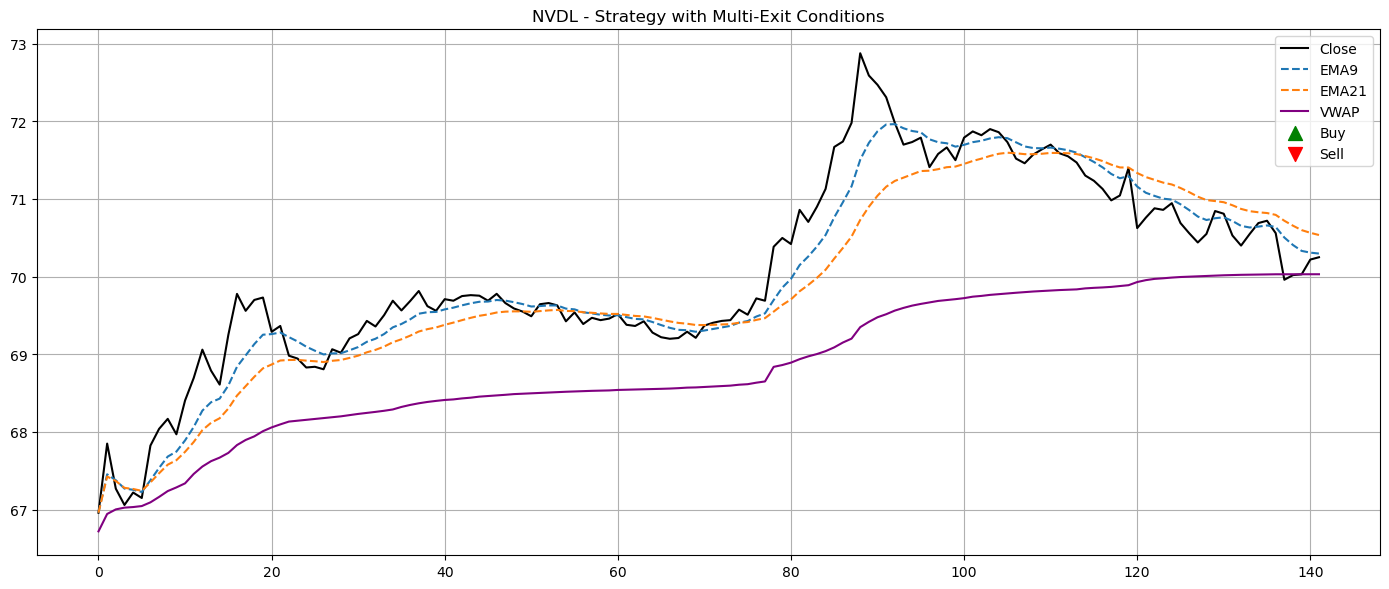

In [68]:
# 买入逻辑
df["Signal"] = 0
df["Up1"] = df["Close"].diff(1).shift(1) > 0
df["Up2"] = df["Close"].diff(2).shift(1) > 0
df["VolUp"] =  df["Volume"].shift(1) > df["Volume"].shift(2) # df["Volume"].shift(0) > df["Volume"].shift(1) #

df.loc[
    (df["EMA9"] > df["EMA21"]) &
    (df["EMA9"].shift(1) <= df["EMA21"].shift(1)) &
    (df["RSI"].between(50, 70)) &
    (df["Up1"]) & (df["Up2"]) &
    (df["VolUp"]),
    "Signal"
] = 1

# 出场逻辑
df["Sell_Signal"] = 0
holding = False
buy_price = 0
buy_time = None
trades = []
for i in range(len(df)):
    row = df.iloc[i]
    time = row.name

    if row["Signal"] == 1:
        holding = True
        buy_price = row["Open"]
        buy_time = time
        buy_datetime = row['Datetime']
    elif holding:
        current_price = row["Close"]
        change_pct = (current_price - buy_price) / buy_price
        duration = (time - buy_time) / 60 if buy_time else 0
        vw_delta = (current_price - row["VWAP"]) / row["VWAP"]
        rsi_prev = df["RSI"].iloc[i - 1] if i > 0 else row["RSI"]

        # 止盈条件
        tp1 = change_pct >= 0.015
        tp2 = row["RSI"] > 70 and row["RSI"] < rsi_prev
        tp3 = vw_delta > 0.025
        if tp1 or tp2 or tp3:
            df.at[time, "Sell_Signal"] = -1
            sell_datetime = row['Datetime']
            holding = False
            if df.at[time, "Sell_Signal"] == -1 and buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": current_price,
                    "Return": change_pct
                })
                # 重置 buy_datetime 避免重复记录
                buy_datetime = None
            continue

        # 止损条件
        sl_conditions = [
            change_pct <= -0.005,
            row["EMA9"] <= row["EMA21"],
            row["RSI"] <= 50,
            row["Close"] < row["VWAP"],
            duration > 15
        ]
        if sum(sl_conditions) >= 2:
            df.at[time, "Sell_Signal"] = -1
            sell_datetime = row['Datetime']
            holding = False
            if df.at[time, "Sell_Signal"] == -1 and buy_datetime and sell_datetime:
                trades.append({
                    "Buy_Time": buy_datetime,
                    "Sell_Time": sell_datetime,
                    "Buy_Price": buy_price,
                    "Sell_Price": current_price,
                    "Return": change_pct
                })
                # 重置 buy_datetime 避免重复记录
                buy_datetime = None

    

results = pd.DataFrame(trades)
if not results.empty:
    print("🔎 回测总结")
    print(results)
    print(f"✅ 总交易次数: {len(results)}")
    print(f"🏆 胜率: {round((results['Return'] > 0).sum() / len(results) * 100, 2)}%")
    print(f"📈 总收益: {round(results['Return'].sum() * 100, 2)}%")
    print(f"💰 每笔平均收益: {round(results['Return'].mean() * 100, 2)}%")


# 提取买卖点
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Sell_Signal"] == -1]

# 绘图展示
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"], label="Close", color="black")
plt.plot(df.index, df["EMA9"], label="EMA9", linestyle="--")
plt.plot(df.index, df["EMA21"], label="EMA21", linestyle="--")
plt.plot(df.index, df["VWAP"], label="VWAP", color="purple")
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="Sell", s=100)
plt.title(f"{ticker} - Strategy with Multi-Exit Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()